# Explore here

In [1]:
# Handle imports up-front
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from math import sqrt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

In [2]:
raw_data_df=sns.load_dataset("flights")
raw_data_df.head()


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [3]:
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   year        144 non-null    int64   
 1   month       144 non-null    category
 2   passengers  144 non-null    int64   
dtypes: category(1), int64(2)
memory usage: 2.9 KB


In [4]:
raw_data_df.describe()

,year,passengers
count,144.000000,144.000000
mean,1954.500000,280.298611
std,3.464102,119.966317
min,1949.000000,104.000000
25%,1951.750000,180.000000
50%,1954.500000,265.500000
75%,1957.250000,360.500000
max,1960.000000,622.000000


In [5]:
raw_data_df.isnull().sum()

year          0
month         0
passengers    0
dtype: int64

## Encode date feature

In [6]:
# Make a copy of the raw data to work with
timeseries_df=raw_data_df.copy()

# Extract the string month to a datetime object feature
timeseries_df['month']=pd.to_datetime(raw_data_df.month, format='%b').dt.month

# Use the month and year to create at 'date' datetime feature
timeseries_df['date']=pd.to_datetime(timeseries_df[['year', 'month']].assign(day=1))

# Set the datetime feature as the index
timeseries_df=timeseries_df.set_index('date')

# Keep only the passenger column
timeseries_df.drop(['year', 'month'], axis=1, inplace=True)

# Re-name 'passengers' to 'dependent_var' so we can easily swap datasets without making
# changes to the notebook
timeseries_df.rename(columns={'passengers': 'dependent_var'}, inplace=True)

# Check the result
timeseries_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype
---  ------         --------------  -----
 0   dependent_var  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


## Baseline model performance

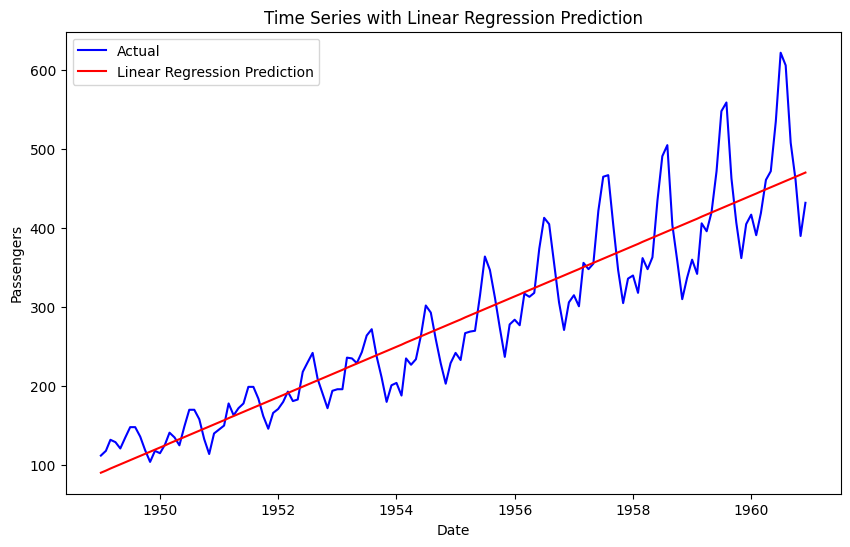

In [7]:
# Create a numeric range for the index as 'X'
X = np.arange(len(timeseries_df)).reshape(-1, 1)  # Reshape for the model

# Dependent variable 'y'
y = timeseries_df['dependent_var']

# Fit a Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict using the linear model
y_pred = model.predict(X)

# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(timeseries_df.index, y, label='Actual', color='blue')
plt.plot(timeseries_df.index, y_pred, label='Linear Regression Prediction', color='red')
plt.xlabel('Date')
plt.ylabel('Passengers')
plt.title('Time Series with Linear Regression Prediction')
plt.legend()
plt.show()

## Missing, and/or extreme values

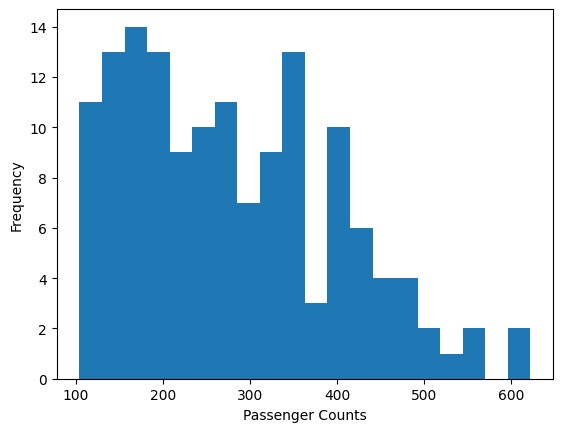

In [8]:
plt.hist(timeseries_df['dependent_var'], bins = 20)
plt.xlabel("Passenger Counts")
plt.ylabel("Frequency")
plt.show()

## Timeseries analysis

In [9]:
print(timeseries_df.columns)

Index(['dependent_var'], dtype='object')


In [10]:
X = np.arange(len(timeseries_df)).reshape(-1, 1)  # Reshape for the model

# Dependent variable 'y'
y = timeseries_df['dependent_var']

# Fit a Linear Regression model
model = LinearRegression()
model.fit(X, y)

# Predict using the linear model
y_pred = model.predict(X)
timeseries_df['baseline_pred'] = model.predict(X)

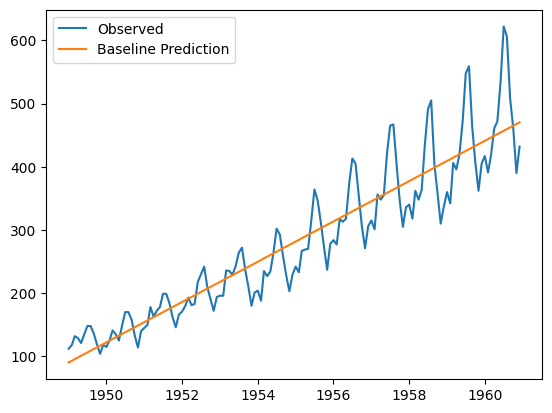

In [11]:
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label = 'Observed')
plt.plot(timeseries_df.index, timeseries_df['baseline_pred'], label = 'Baseline Prediction')
plt.legend()
plt.show()

In [12]:
timeseries_df = timeseries_df.resample('MS').mean()
timeseries_df

,dependent_var,baseline_pred
date,,
1949-01-01,112.0,90.309962
1949-02-01,118.0,92.967146
1949-03-01,132.0,95.624330
1949-04-01,129.0,98.281513
1949-05-01,121.0,100.938697
...,...,...
1960-08-01,606.0,459.658525
1960-09-01,508.0,462.315709
1960-10-01,461.0,464.972893


Datetime axis is regular: False
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-31 to 1960-12-31
Freq: ME
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   dependent_var  144 non-null    float64
 1   baseline_pred  144 non-null    float64
dtypes: float64(2)
memory usage: 3.4 KB


/tmp/ipykernel_10286/1388203475.py:17: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  resampled_timeseries_df=resampled_timeseries_df.resample('M').interpolate()


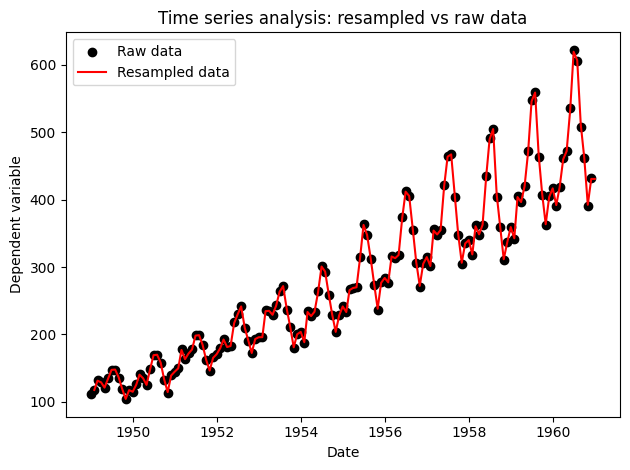

In [13]:
# Take the difference across the datetime index
diff=np.diff(timeseries_df.index.to_numpy())

# Check that all of the differences are equal
equaly_spaced=np.all(diff==diff[0])

print(f'Datetime axis is regular: {equaly_spaced}')

# If the datetime axis not regular - resample it and fill in the
# missing timepoints with interpolation
if equaly_spaced == False:

    # Resample down to days first
    resampled_timeseries_df=timeseries_df.resample('D').interpolate()

    # Then resample back up to months
    resampled_timeseries_df=resampled_timeseries_df.resample('M').interpolate()
    resampled_timeseries_df.info()

    # Plot the results to be sure we diden't deform anything too badly...
    plt.title('Time series analysis: resampled vs raw data')
    plt.scatter(timeseries_df.index, timeseries_df['dependent_var'], label='Raw data', color='black')
    plt.plot(resampled_timeseries_df.index, resampled_timeseries_df['dependent_var'], label='Resampled data', color='red')
    plt.xlabel('Date')
    plt.ylabel('Dependent variable')
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

    timeseries_df=resampled_timeseries_df

## Stationarity

In [14]:
from statsmodels.tsa.stattools import adfuller

dftest=adfuller(timeseries_df['dependent_var'], autolag = "AIC")
print(f'Dicky-Fuller p-value: {dftest[1]:.3f}')

Dicky-Fuller p-value: 0.984


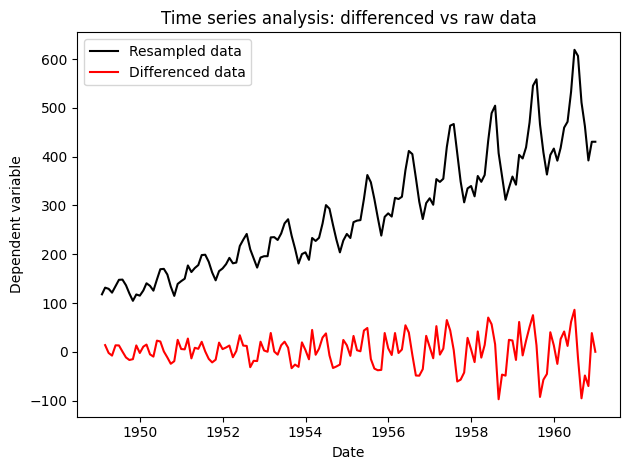

In [15]:
stationary_timeseries_df=timeseries_df['dependent_var'].diff().dropna()

plt.title('Time series analysis: differenced vs raw data')
plt.plot(timeseries_df.index, timeseries_df['dependent_var'], label='Resampled data', color='black')
plt.plot(stationary_timeseries_df.index, stationary_timeseries_df, label='Differenced data', color='red')
plt.xlabel('Date')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

## Model training

In [16]:
from pmdarima import auto_arima
timeseries_model=auto_arima(timeseries_df['dependent_var'], seasonal=True, stationary=False, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1012.628, Time=0.94 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1021.005, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1012.917, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1013.833, Time=0.12 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1012.119, Time=0.70 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1011.298, Time=0.19 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1011.809, Time=0.65 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1016.507, Time=0.14 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1016.547, Time=0.09 sec
 ARIMA(3,1,2)(0,1,0)[12]             : AIC=inf, Time=0.44 sec
 ARIMA(2,1,3)(0,1,0)[12]             : AIC=1012.999, Time=0.19 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1014.559, Time=0.05 sec
 ARIMA(1,1,3)(0,1,0)[12]             : AIC=1010.846, Time=0.24 sec
 ARIMA(1,1,3)(1,1,0)[12]             : AIC=1010.976, Time=0.38 sec
 ARIMA(1,1,3)(0,1,1)[12]

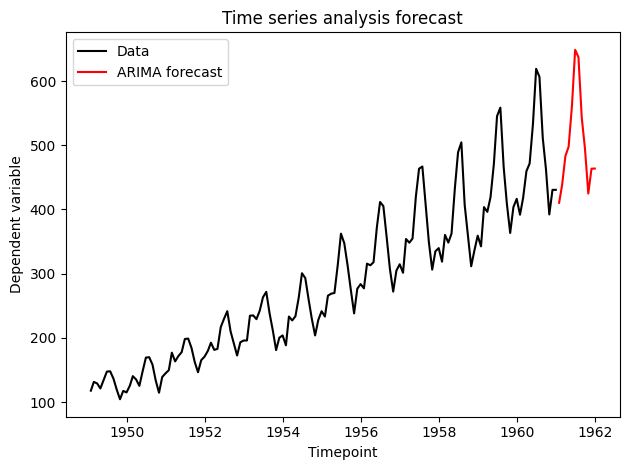

In [17]:
# Make predictions for the next 12 timepoints into the future
forecast=timeseries_model.predict(12)

plt.title('Time series analysis forecast')
plt.plot(timeseries_df['dependent_var'], label='Data', color='black')
plt.plot(forecast, label='ARIMA forecast', color='red')
plt.xlabel('Timepoint')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

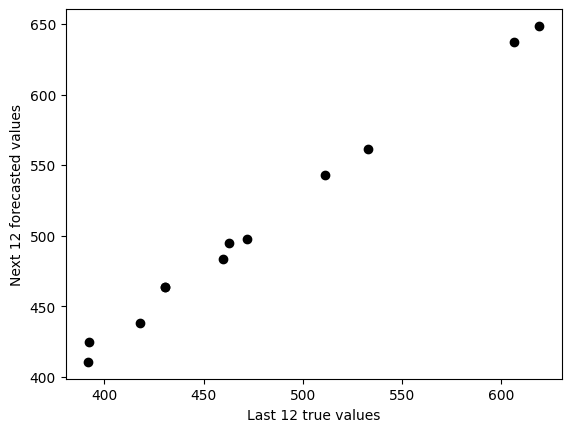

In [18]:
# Get the last 12 timepoints from the real data
true_data=timeseries_df['dependent_var'][-12:]

# Plot them against the predictions
plt.scatter(true_data, forecast, color='black')
plt.xlabel('Last 12 true values')
plt.ylabel('Next 12 forecasted values')
plt.show()


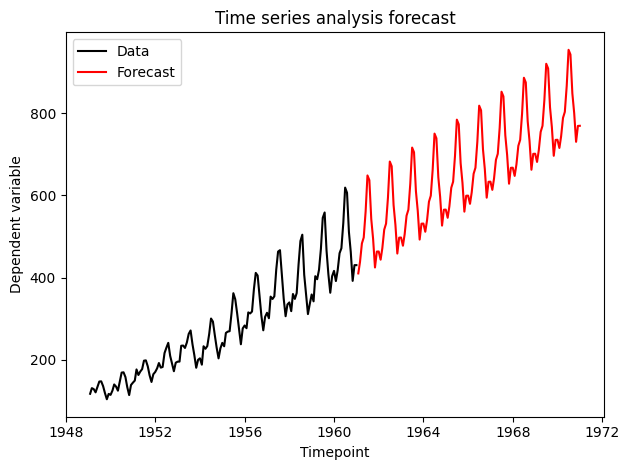

In [19]:
# Make predictions for the next 120 timepoints into the future
forecast=timeseries_model.predict(120)

plt.title('Time series analysis forecast')
plt.plot(timeseries_df['dependent_var'], label='Data', color='black')
plt.plot(forecast, label='Forecast', color='red')
plt.xlabel('Timepoint')
plt.ylabel('Dependent variable')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [20]:
# Set a forecast horizon, i.e. how far into the future, we want to predict
forecast_horizon=6

# Set a model order, i.e. how many past datapoints should be used as input for prediction
model_order=36

## Test-train split

In [21]:
# Make the test set one forecast horizon in length
testing_dataset_size=forecast_horizon

# Calculate how long the training set needs to be
training_set_size=len(timeseries_df) - testing_dataset_size

# Get the training and testing sets
training_data=timeseries_df[:training_set_size]
testing_data=timeseries_df[training_set_size:]

## Cross-validation

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=175.674, Time=0.69 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=178.796, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=171.344, Time=0.19 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=175.555, Time=0.08 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=251.740, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=170.231, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=171.392, Time=0.07 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=173.265, Time=0.29 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=171.868, Time=0.15 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=171.995, Time=0.11 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=173.796, Time=0.03 sec
 ARIMA(2,0,1)(0,1,0)[12] intercept   : AIC=173.827, Time=0.13 sec
 ARIMA(1,0,0)(0,1,0)[12]             : AIC=176.232, Time=0.02 sec

Best model:  ARIMA(1,0,0)(0,1,0)[12] intercept
Total fit time: 1.839 seconds
Performing stepwise s

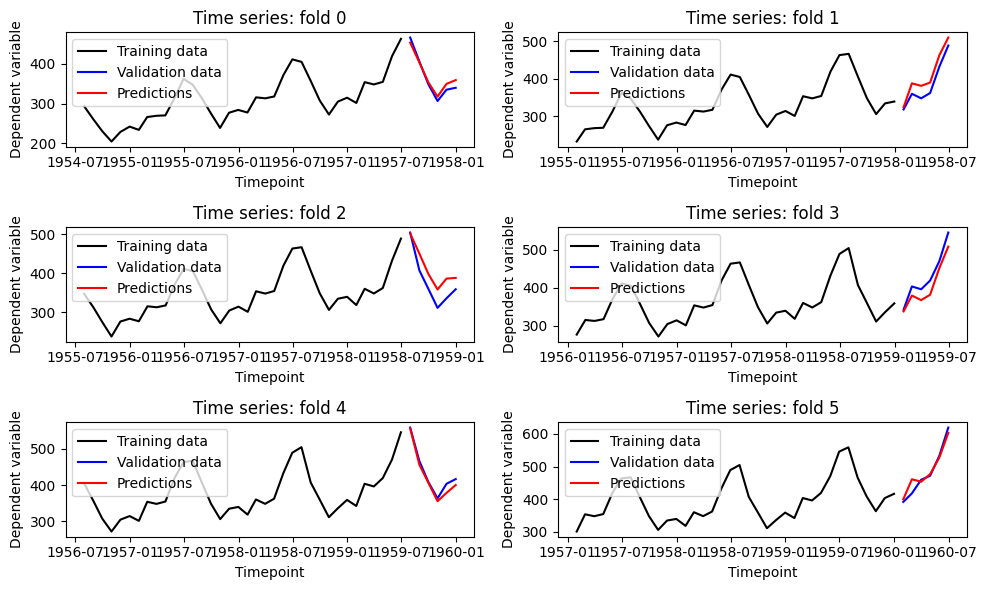

In [22]:
# Number of 'cross-validation' folds to run
folds=6

# Holders to collect data for later
validation_rmse_values=[]
predicted_values=[]
validation_values=[]

# Set-up a multiplot for the results
fig, axs=plt.subplots(3, 2, figsize=(10,6))
axs=axs.flatten()

# Instantiate a time series splitter
timeseries_splits=TimeSeriesSplit(n_splits=folds, max_train_size=model_order, test_size=forecast_horizon)

# Loop on the splits with a counter
for i, timeseries_split in enumerate(timeseries_splits.split(training_data)):

    # Recover the split indicies
    training_indicies=timeseries_split[0]
    validation_indicies=timeseries_split[1]

    # Get the data for this split from the training data
    fold_training_data=training_data.iloc[training_indicies, :]
    fold_validation_data=training_data.iloc[validation_indicies, :]

    # Fit the model and predict out to the forecast horizon
    timeseries_model=auto_arima(fold_training_data['dependent_var'], stationary=False, trace=True, seasonal=True, m=12, suppress_warnings=True)
    forecast=timeseries_model.predict(forecast_horizon)

    # Collect intermediate results
    predicted_values.extend(forecast)
    validation_values.extend(fold_validation_data['dependent_var'])

    rmse=sqrt(mean_squared_error(fold_validation_data['dependent_var'], forecast))
    validation_rmse_values.append(rmse)

    # Draw the timeseries plot for this fold
    axs[i].set_title(f'Time series: fold {i}')
    axs[i].plot(fold_training_data['dependent_var'], label='Training data', color='black')
    axs[i].plot(fold_validation_data['dependent_var'], label='Validation data', color='blue')
    axs[i].plot(forecast, label='Predictions', color='red')
    axs[i].set_xlabel('Timepoint')
    axs[i].set_ylabel('Dependent variable')
    axs[i].legend(loc='best')

plt.tight_layout()
plt.show()

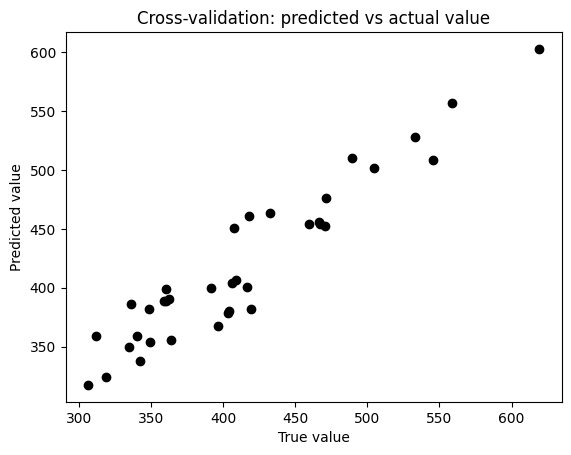

In [23]:
# Plot the forcasted values against the true values
plt.title('Cross-validation: predicted vs actual value')
plt.scatter(validation_values, predicted_values, color='black')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.show()

In [27]:
rmse_results = {}
print(f'Cross-validation RMSE: {np.mean(validation_rmse_values):.1f}+/-{np.std(validation_rmse_values):.1f}')
rmse_results['ARIMA cross-validation mean']=np.mean(validation_rmse_values)

Cross-validation RMSE: 22.8+/-9.1


## Model evaluation

In [28]:
timeseries_model=auto_arima(training_data['dependent_var'], stationary=False, seasonal=True, trace=True, m=12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=969.238, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=961.838, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=962.689, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=961.254, Time=0.05 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=962.205, Time=0.11 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.67 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=963.026, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=962.740, Time=0.05 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=961.930, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=964.709, Time=0.12 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=962.832, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 2.329 seconds


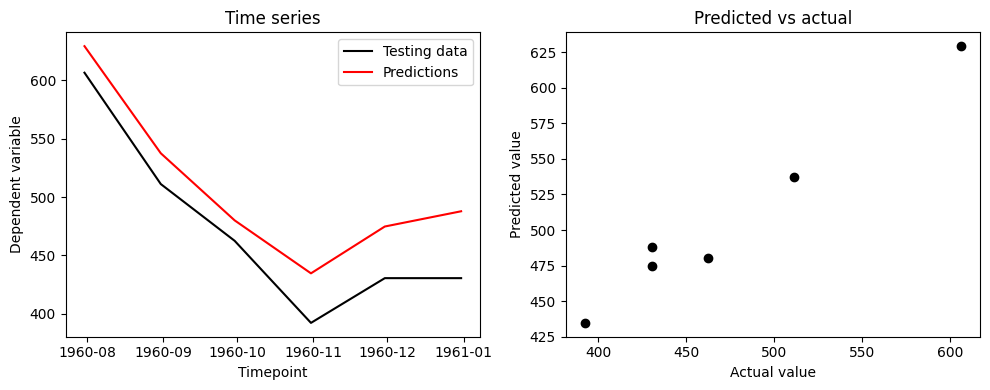

In [29]:
# Make predictions
forecast=timeseries_model.predict(forecast_horizon)

# Plot the result
fig, (ax1, ax2)=plt.subplots(1,2, figsize=(10,4))

ax1.set_title('Time series')
ax1.plot(testing_data['dependent_var'], label='Testing data', color='black')
ax1.plot(forecast, label='Predictions', color='red')
ax1.set_xlabel('Timepoint')
ax1.set_ylabel('Dependent variable')
ax1.legend(loc='best')

ax2.set_title('Predicted vs actual')
ax2.scatter(testing_data['dependent_var'], forecast, color='black')
ax2.set_xlabel('Actual value')
ax2.set_ylabel('Predicted value')

plt.tight_layout()
plt.show()

In [30]:
# Calculate RMSE on test set
rmse=sqrt(mean_squared_error(testing_data['dependent_var'], forecast))
rmse_results['ARIMA test data']=rmse

print(f'Root mean square error:')

for experiment, rmse in rmse_results.items():
    print(f'  {experiment}: {rmse:.1f}')

Root mean square error:
  ARIMA cross-validation mean: 22.8
  ARIMA test data: 37.8
